<a href="https://colab.research.google.com/github/Luciferxx/Semantic_Classification-Road_Detection/blob/main/Semantic_Classification_Using_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.09G/5.11G [01:11<00:00, 89.6MB/s]
100% 5.11G/5.11G [01:11<00:00, 76.6MB/s]


In [ ]:
!cp /content/lyft-udacity-challenge.zip /content/drive/"My Drive"/"Segmantic Classification" 

In [1]:
import os
os.chdir("drive/My Drive/Segmantic Classification")

In [2]:
!pwd


/content/drive/My Drive/Segmantic Classification


In [3]:
image_path = 'dataA/dataA/CameraRGB/'
mask_path = 'dataA/dataA/CameraSeg/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

Text(0.5, 1.0, 'Segmentation')

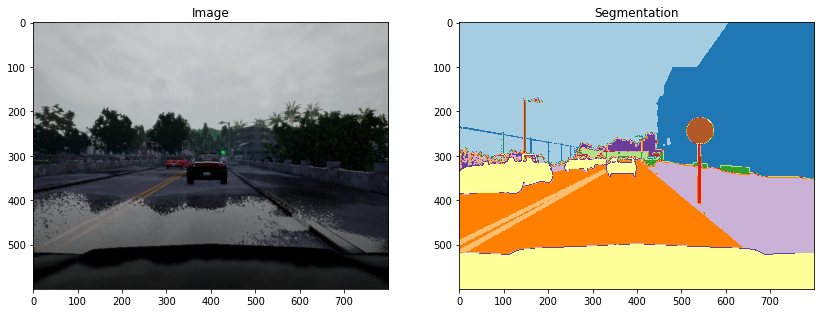

In [4]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

The images comparison shown above depicts the problem in the dataset which is that they both are insimilar. So we will just stick to road detection because it will cause misclassification which we dont want in our case. 

In [5]:
import cv2
from tqdm import tqdm
mask_imgs = []
org_imgs = []
l = list(zip(image_list,mask_list))
def preprocess(path,mask_path):
  img=cv2.imread(path)
  mask = cv2.imread(mask_path)
  mask=np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0],img.shape[1])
  #Since Images in the data set are quite noisy we would just go ahead with road detection
  mask = (mask==7) #Road Detection
  return img,mask

In [6]:
mask_imgs = []
org_imgs = []
for i,m in tqdm(l) :
  img,mask = preprocess(i,m)
  org_imgs.append(img)
  mask_imgs.append(mask)


100%|██████████| 1000/1000 [40:16<00:00,  2.42s/it]


In [13]:
mask_imgs = np.array(mask_imgs,dtype=np.float32)
org_imgs  = np.array(org_imgs)

In [14]:
mask_imgs.shape

(1000, 600, 800)

In [15]:
org_imgs.shape

(1000, 600, 800, 3)

In [16]:
train_imgs = org_imgs[:700]
test_imgs = org_imgs[700:]
train_mask = mask_imgs[:700]
test_mask = mask_imgs[700:]

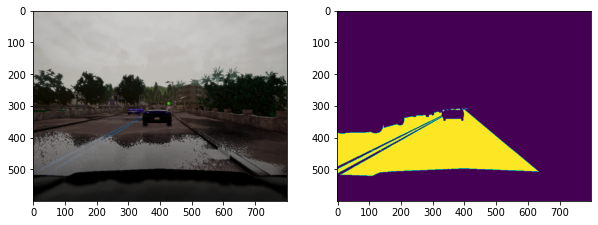

In [101]:
fig,ax=plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(train_imgs[1])
ax[1].imshow(train_mask[1])

In [40]:
train_mask[1].shape

(600, 800)

In [18]:
np.unique(train_mask[1])

array([0., 1.], dtype=float32)

In [19]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU

In [23]:
input_img = Input((600,800, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 600, 800, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 600, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 600, 800, 8)  584         conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 300, 400, 8)  0           conv2d_16[0][0]                  
_______________________________________________________________________________________

In [24]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v2.h5', verbose=1, save_best_only=True)
]
results = model.fit(train_imgs, train_mask, batch_size=16, epochs=5, callbacks=callbacks,
                    validation_data=(test_imgs, test_mask))

Epoch 1/5
44/44 [==============================] - ETA: 0s - loss: 0.6305 
Epoch 00001: val_loss improved from inf to 0.47789, saving model to model-sdc-seg-v2.h5
44/44 [==============================] - 1567s 36s/step - loss: 0.6305 - val_loss: 0.4779
Epoch 2/5
44/44 [==============================] - ETA: 0s - loss: 0.4529 
Epoch 00002: val_loss improved from 0.47789 to 0.41471, saving model to model-sdc-seg-v2.h5
44/44 [==============================] - 1561s 35s/step - loss: 0.4529 - val_loss: 0.4147
Epoch 3/5
44/44 [==============================] - ETA: 0s - loss: 0.4038 
Epoch 00003: val_loss improved from 0.41471 to 0.39867, saving model to model-sdc-seg-v2.h5
44/44 [==============================] - 1561s 35s/step - loss: 0.4038 - val_loss: 0.3987
Epoch 4/5
44/44 [==============================] - ETA: 0s - loss: 0.3668 
Epoch 00004: val_loss improved from 0.39867 to 0.36795, saving model to model-sdc-seg-v2.h5
44/44 [==============================] - 1569s 36s/step - loss: 0.

In [25]:
model.save('seg_model/1/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: seg_model/1/assets


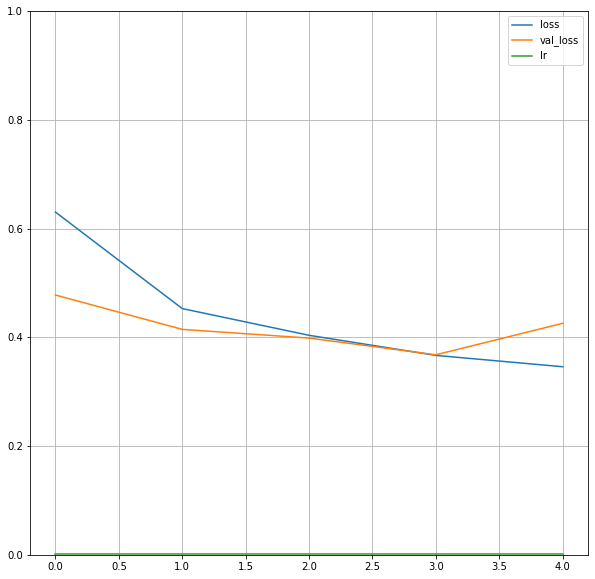

In [27]:
import pandas as pd
pd.DataFrame(results.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [98]:
def generate_mask(img,threshold=0.45):
  # img = cv2.imread(img)
  img  = np.array(img)
  pred_mask=model.predict(img.reshape(-1,600,800,3))
  mat=np.squeeze(pred_mask[0])
  fig,axes=plt.subplots(1,2,figsize=(10,10))
  #Refining the mask
  b=np.array([max(mat[i,j],1) if mat[i,j]>threshold else 0 for i in range(mat.shape[0]) for j in range(mat.shape[1]) ]).reshape(600,800)
  axes[0].imshow(img)
  axes[0].set_title('Original Image')
  axes[1].set_title('Masked  Image')
  axes[1].imshow(b)
  plt.show()
  return b
def generate_masked_image(mask,img):
  # img = cv2.imread(img)
  img  = np.array(img)
  fig,axes=plt.subplots(1,2,figsize=(10,10))
  #Masking the original image in the order of RGB with the help of Mask
  c=np.array([x[i,j,k] if mask[i,j]==1 else 1 for i in range(img.shape[0]) for j in range(img.shape[1]) for k in range(img.shape[2])]).reshape(600,800,3)
  axes[0].imshow(img)
  axes[0].set_title('Original Image')
  axes[1].set_title('Masked Original Image')
  axes[1].imshow(c)
  plt.show()
  return c

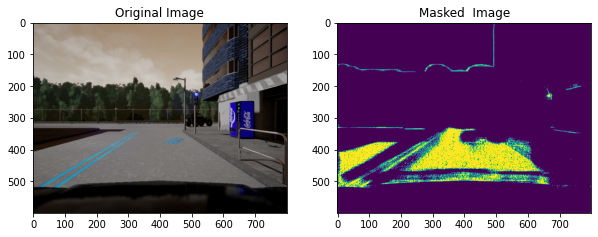

In [99]:
a = generate_mask(train_imgs[-1])

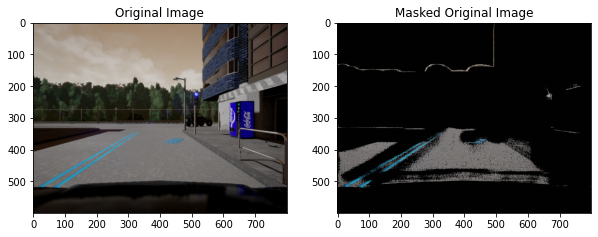

In [100]:
b = generate_masked_image(a,train_imgs[-1])